In [1]:
import os
import sys
import glob

sys.path.append(os.getcwd())

import torch
from lossless.component.coolchic import CoolChicEncoderParameter
from lossless.component.frame import load_frame_encoder
from lossless.component.types import NAME_COOLCHIC_ENC
from lossless.component.image import (
    FrameEncoderManager,
    encode_one_frame,
)
from enc.utils.codingstructure import CodingStructure, Frame
from typing import Any, Dict, List
from lossless.component.coolchic import CoolChicEncoder
from torchac import torchac
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lossless.util.config import (
    DATASET_PATH,
    TEST_WORKDIR,
    PATH_COOL_CHIC_CFG,
    IMAGE_PATHS,
    args,
    start_print
)
from lossless.util.print_formatting import pretty_str_dict
from lossless.util.parsecli import change_n_out_synth, get_coolchic_param_from_args, get_manager_from_args
from lossless.util.misc import clean_workdir
from lossless.training.train import train
from lossless.util.encoding import encode, decode

print(IMAGE_PATHS)
print(pretty_str_dict(args))
print("----------")
print(start_print)

frame_encoder_manager = FrameEncoderManager(**get_manager_from_args(args))

Using /home/jakub/.cache/torch_extensions/py310_cu126 as PyTorch extensions root...
Emitting ninja build file /home/jakub/.cache/torch_extensions/py310_cu126/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module torchac_backend...


ninja: no work to do.
['/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim02.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim03.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim04.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim05.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim06.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim07.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim08.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim09.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim10.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/k

In [2]:
clean_workdir(args["workdir"])

Removing /home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/test-workdir/...


/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png


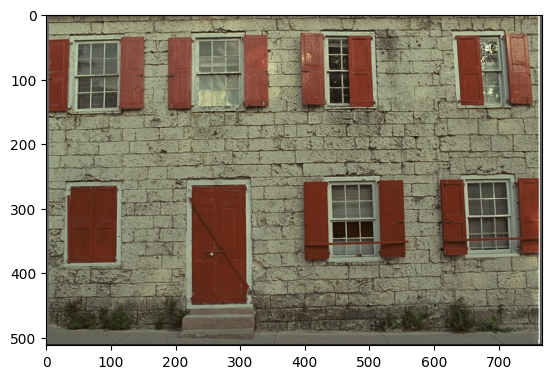

torch.Size([1, 3, 512, 768])


In [3]:
print(args["input"])
im = cv2.imread(filename=args["input"])
assert im is not None, f"Failed to read image {args['input']}"
im = im[:, :, ::-1]  # Convert BGR to RGB
plt.imshow(im)
plt.show()

im = im.transpose(2, 0, 1)[None,]  # Change to CxHxW
im_tensor = torch.from_numpy(im.copy()).float() / 255.0  # Normalize to [0, 1]
print(im_tensor.shape)
im_tensor = im_tensor.to("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
encoder_param = CoolChicEncoderParameter(
    **get_coolchic_param_from_args(args, "residue")
)
encoder_param.set_image_size((512, 768))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 6
)

coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
# coolchic.eval()

# for i, grid in enumerate(coolchic.latent_grids):
#     # Instead of default initialization, use larger values
#     grid.data.normal_(0.2, 0.5)  # Mean=0, std=0.5 instead of very small values
#     print(f"   Reinitialized Grid {i}: mean={grid.data.mean():.4f}, std={grid.data.std():.4f}")

# print(coolchic.pretty_string(True))


In [5]:
frame_encoder = train(
    model=coolchic,
    target_image=im_tensor,
    frame_encoder_manager=frame_encoder_manager,
    start_lr=args["start_lr"],
    lmbda=args["lmbda"],
    cosine_scheduling_lr=args["schedule_lr"],
    max_iterations=args["n_itr"],
    frequency_validation=args["freq_valid"],
    patience=args["patience"],
    optimized_module=args["optimized_module"],
    quantizer_type=args["quantizer_type"],
    quantizer_noise_type=args["quantizer_noise_type"],
    softround_temperature=args["softround_temperature"],
    noise_parameter=args["noise_parameter"],
)

Loss: 8.6644, Rate NN: 0.0000, Rate Latent: 1.0433, Rate Img: 7.6211
Loss: 8.7184, Rate NN: 0.0000, Rate Latent: 1.0259, Rate Img: 7.6925
Loss: 9.0363, Rate NN: 0.0000, Rate Latent: 0.8792, Rate Img: 8.1570
Loss: 10.5460, Rate NN: 0.0000, Rate Latent: 0.6880, Rate Img: 9.8580
Loss: 8.8894, Rate NN: 0.0000, Rate Latent: 0.5160, Rate Img: 8.3734
Loss: 8.7979, Rate NN: 0.0000, Rate Latent: 0.2090, Rate Img: 8.5889
Loss: 8.8077, Rate NN: 0.0000, Rate Latent: 0.0351, Rate Img: 8.7726
Loss: 8.8771, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.8771
Loss: 8.5680, Rate NN: 0.0000, Rate Latent: 0.8718, Rate Img: 7.6961
Loss: 8.5317, Rate NN: 0.0000, Rate Latent: 0.8623, Rate Img: 7.6694
Loss: 8.1943, Rate NN: 0.0000, Rate Latent: 0.2141, Rate Img: 7.9802
Loss: 7.6949, Rate NN: 0.0000, Rate Latent: 0.1183, Rate Img: 7.5767
Loss: 7.9832, Rate NN: 0.0000, Rate Latent: 0.0591, Rate Img: 7.9241
Loss: 8.3978, Rate NN: 0.0000, Rate Latent: 0.0356, Rate Img: 8.3621
Loss: 8.2781, Rate NN: 0.0000, Ra

In [7]:
with torch.no_grad():
    # Forward pass with no quantization noise
    # This is a random prior, i.e. the output is not conditioned on any input
    # image.
    random_prior = coolchic.forward(
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
print(f"Random prior: {random_prior.keys()}")

Random prior: dict_keys(['raw_out', 'rate', 'latent_bpd', 'additional_data'])


torch.Size([1, 6, 512, 768])
torch.Size([524256])
tensor(-0.5035, device='cuda:0') tensor(6.9564, device='cuda:0')


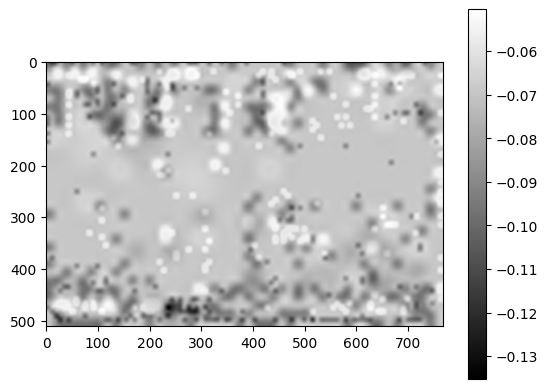

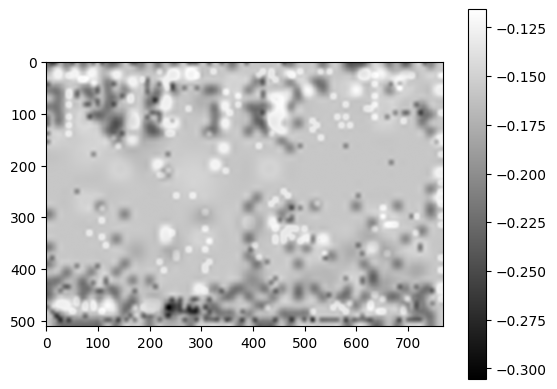

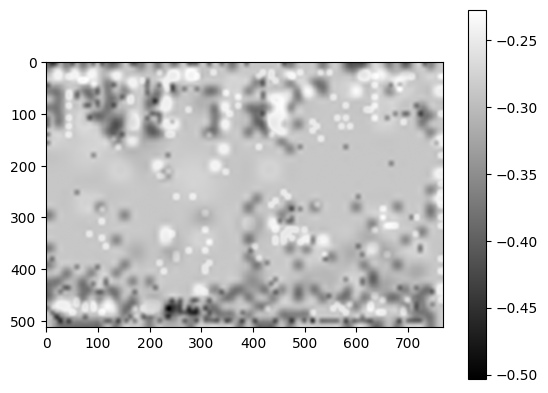

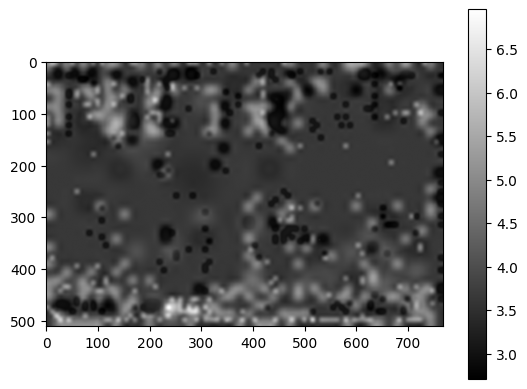

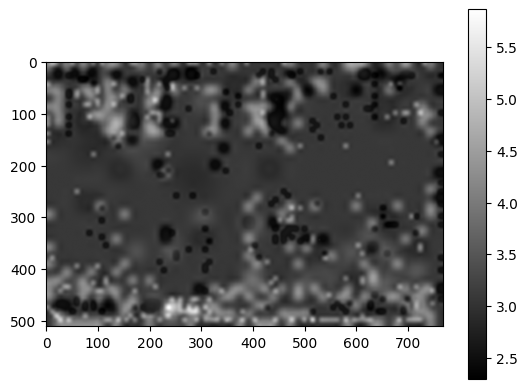

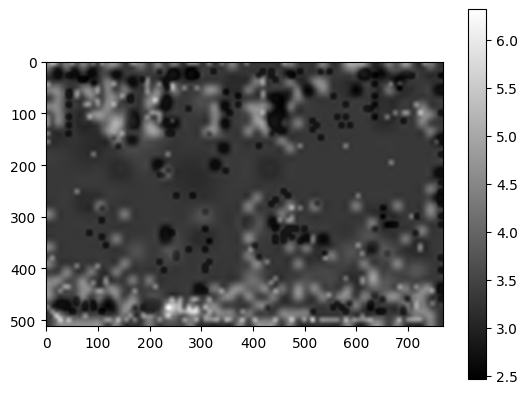

In [8]:
# 
print(random_prior["raw_out"].size())
print(random_prior["rate"].size())
# print(random_prior["additional_data"])
print(torch.min(random_prior["raw_out"]), torch.max(random_prior["raw_out"]))

for slice_index in range(6):
    image_tensor_2d = random_prior["raw_out"].cpu().numpy()[0, slice_index]
    plt.imshow(
        image_tensor_2d,
        cmap="gray",
    )
    plt.colorbar()
    plt.show()

In [9]:
coolchic.size_per_latent

[(1, 1, 512, 768),
 (1, 1, 256, 384),
 (1, 1, 128, 192),
 (1, 1, 64, 96),
 (1, 1, 32, 48),
 (1, 1, 16, 24),
 (1, 1, 8, 12)]

In [10]:
mu = random_prior["raw_out"][:, :3]
scale = random_prior["raw_out"][:, 3:6]
clamp_scale_to = 0.2
scale = torch.clamp(scale,min = clamp_scale_to, max=clamp_scale_to)
# scale = torch.clamp(scale, min=0.005, max = 0.05)
mu = torch.clamp(mu,min = -1, max=1)
print(f"mu: {mu.min()} {mu.max()}, scale: {scale.min()} {scale.max()}")
encoded_bytes = encode(im_tensor, mu, scale)

mu: -0.5035250186920166 -0.05035482347011566, scale: 0.20000000298023224 0.20000000298023224
Channel 0: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 1: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 2: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255


In [11]:
def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels

print(get_bits_per_pixel(768, 512, 3, encoded_bytes))

7.388888888888889


In [12]:
best_bpd = 2.8752034505208335
if get_bits_per_pixel(768, 512, 3, encoded_bytes) < best_bpd:
    best_bpd = get_bits_per_pixel(768, 512, 3, encoded_bytes)
    print(f"Best BPD: {best_bpd}")

In [13]:
print(encoded_bytes[0][:10])

b'Y\x19\xd9@\x04\x9f\x914\x9d"'


Decoded R: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded G: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded B: shape torch.Size([1, 1, 512, 768]), min 0, max 255
0.0 1.0


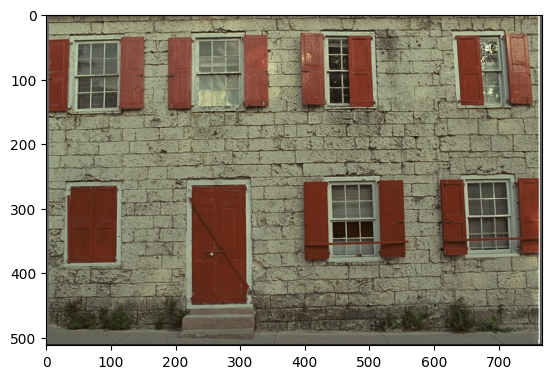

PNG bpd: 4.995 vs New lossless method: 7.389


In [14]:

decoded_im = decode(encoded_bytes, mu, scale)
decoded_im = decoded_im.cpu().numpy()
print(np.min(decoded_im), np.max(decoded_im))

# decoded_im has shape torch.Size([1, 3, 512, 768])
# show it via plt

# decoded_im is a numpy array with shape (1, 3, 512, 768)
# To display as an image, we need shape (512, 768, 3)
plt.imshow(np.transpose(decoded_im[0], (1, 2, 0)))
plt.show()
assert np.allclose(decoded_im, im_tensor.cpu().numpy()), "Decoded image does not match original"
print(f"PNG bpd: {736501 / 768 / 512 / 3 * 8:.3f} vs New lossless method: {get_bits_per_pixel(768, 512, 3, encoded_bytes):.3f}")

In [15]:
# Let's verify the fix worked by checking reconstruction
print("🔍 VERIFYING LOSSLESS RECONSTRUCTION:")
print("-" * 40)

print(f"Original image shape: {im_tensor.shape}")
print(f"Original image range: [{im_tensor.min():.6f}, {im_tensor.max():.6f}]")

print(f"\nDecoded image shape: {decoded_im.shape}")
print(f"Decoded image range: [{decoded_im.min():.6f}, {decoded_im.max():.6f}]")

# Check if reconstruction is perfect (lossless)
reconstruction_error = np.abs(im_tensor.cpu().numpy() - decoded_im).max()
print(f"\nMax reconstruction error: {reconstruction_error:.10f}")

if reconstruction_error < 1e-6:
    print("✅ SUCCESS: Perfect lossless reconstruction!")
else:
    print(f"❌ ISSUE: Reconstruction error = {reconstruction_error}")
    
    # Let's check per channel
    for i in range(3):
        channel_error = np.abs(im_tensor[0, i].cpu().numpy() - decoded_im[0, i]).max()
        print(f"   Channel {i} error: {channel_error:.10f}")

# Check some statistics
print(f"\nChannel statistics:")
for i in range(3):
    orig_mean = im_tensor[0, i].mean().item()
    decoded_mean = decoded_im[0, i].mean()
    print(f"   Channel {i}: Original mean={orig_mean:.6f}, Decoded mean={decoded_mean:.6f}")

🔍 VERIFYING LOSSLESS RECONSTRUCTION:
----------------------------------------
Original image shape: torch.Size([1, 3, 512, 768])
Original image range: [0.000000, 1.000000]

Decoded image shape: (1, 3, 512, 768)
Decoded image range: [0.000000, 1.000000]

Max reconstruction error: 0.0000000000
✅ SUCCESS: Perfect lossless reconstruction!

Channel statistics:
   Channel 0: Original mean=0.469652, Decoded mean=0.469652
   Channel 1: Original mean=0.426456, Decoded mean=0.426456
   Channel 2: Original mean=0.346614, Decoded mean=0.346614
